In [1]:
# -------------------------------------------- 
# 
# iEBM local vs non-local decomposition plots
# 
# with amount effect scatterplots
# 
# -------------------------------------------- 
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import mpl_toolkits
import glob
import pandas as pd
import xarray as xr
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import scipy.stats
import scipy.integrate
import cmocean.cm as cmo
import seaborn as sns # used for discrete
import matplotlib.colors as colors
import matplotlib.ticker as ticker
# from initialize import *


In [2]:
# SAVE FIGURES ?  -------------------------------
figsave_on = False
saveHere = ""    # where to save figure panels

# read in data ----------------------------------
run_218GS = '733a_hiRes_218ka_367ppm_darkSah_baseline_1000kmLocal' #  '733hiRes_218ka_367ppm_darkSah_baseline' 
maindir = '/DISTRIBUTE/data_and_analysis'  # [CHANGE!] to correct path
# make path
clim_fn_218GS = os.path.join(run_218GS, "results", run_218GS + "_CLIM.nc")

# climate ncdf
ds218gs = xr.open_dataset(os.path.join(maindir, clim_fn_218GS)) 
# print clim
ds218gs

<xarray.Dataset>
Dimensions:                                  (lon: 144, lat: 96, time: 2,
                                              yr_slice: 2)
Coordinates:
  * lon                                      (lon) float64 0.0 2.5 ... 357.5
  * lat                                      (lat) float64 -90.0 -88.11 ... 90.0
  * time                                     (time) float64 0.0 1.0
  * yr_slice                                 (yr_slice) <U5 'mjjas' 'ndjfm'
Data variables: (12/39)
    SOLIN                                    (yr_slice, time, lat, lon) float32 ...
    FSDSC                                    (yr_slice, time, lat, lon) float32 ...
    FSNSC                                    (yr_slice, time, lat, lon) float32 ...
    albedo_clr_surf                          (yr_slice, time, lat, lon) float32 ...
    PRECT                                    (yr_slice, time, lat, lon) float32 ...
    ET                                       (yr_slice, time, lat, lon) float32 ...
    ...                                       ...
    Esource_frac_land                        (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_localEffect_upwind_l1000        (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_regEffect_upwind_g1000          (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_localRegional_upwind_effectSum  (yr_slice, lat, lon, time) float64 ...
    Dtau_bar_distTo75perc_upwind             (yr_slice, lat, lon, time) float64 ...
    Dtau_bar                                 (yr_slice, lat, lon, time) float64 ...

In [3]:
# --- compute d18O
#     oxygen isotopes are highly correlated with our tau-bar (water vapor attenuation)
#     variable. We adapt the correlation relationship of Siler et al. (in prep)
tau_d18_scale = -10   # slope of taubar vs d18O
tau_d18_intercept = 3 # y-intercept
# apply regression
ds218gs['d18O_est'] = ds218gs['tau_bar'] * tau_d18_scale + tau_d18_intercept
# and to the Dtau (just Dtau * slope)
ds218gs['Dd18O_est'] = ds218gs['Dtau_bar'] * tau_d18_scale 

# --- compute weighted mean 
#     (this cell may take a couple minutes to run if ds_clim is a big file)
# 218gs -- get precip-weighted mean
wts = ds218gs['PRECT'] / ds218gs['PRECT'].sum(dim='yr_slice')
wtd_avg_ds = (ds218gs * wts).sum(dim='yr_slice')
new_timeslice = wtd_avg_ds.expand_dims(yr_slice=['ann_prWtd'])
ds218gs = xr.concat([ds218gs, new_timeslice], dim='yr_slice')

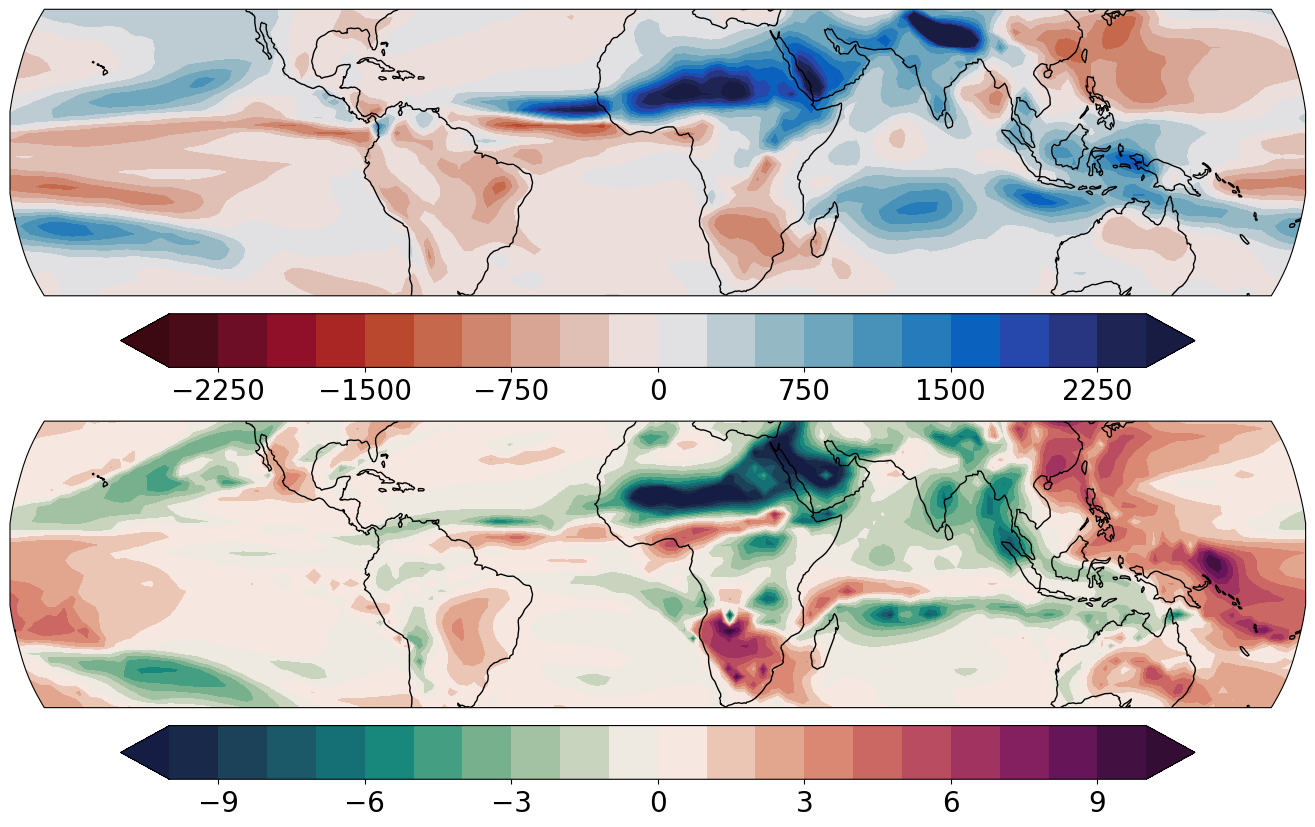

In [4]:
# --- MAP - precipitation and d18O anomalies
fname = "DarkSah218gs_anoms_P_d18.png"
# ... select colormap
mycmap = cmo.balance_r   # https://matplotlib.org/cmocean/
mycmap_d18 = cmo.curl

# ... select Dd18O range to consider
d18_var = "d18O_est"
clim_var = "PRECT"
# d18 range
d18min, d18max = -10, 10
# precip range [mm month-1]
prmin, prmax = -250*10, 250*10
# - p conversion factor [kg m-2 s-1 to mm month-1]
# pFac = 86400 * 30
# - p conversion factor [kg m-2 s-1 to mm yr-1]
pFac = 86400 * 365

# ... set ylims
minlat, maxlat = -35, 35
# ... add cyclic point to remove bar at 0 lon
lon, lat = ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.).coords['lon'], ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.).coords['lat']
ds218gs_d18, lonc = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.)[d18_var], coord=lon)
ds218gs_p, _ = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.)[clim_var], coord=lon)
dsctrl_d18, _ = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=0.)[d18_var], coord=lon)
dsctrl_p, _ = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=0.)[clim_var], coord=lon)

# colorbar properties
leg_shrink = 0.75    # [0-1]
leg_orient = "horizontal"
txtsize = 20

# ... PLOT [case minus ctrl]
spec = gridspec.GridSpec(ncols=1, nrows=2, hspace=0.15, wspace=0.05)
plt.figure(figsize=(25,10))

# TOP LEFT -- PRECIPITATION ANOMALY; 218
ax = plt.subplot(spec[0], projection=ccrs.Robinson())
plt.contourf(lonc, lat, (ds218gs_p-dsctrl_p)*pFac, np.linspace(prmin, prmax, 21), 
             transform=ccrs.PlateCarree(), cmap=mycmap, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents

# BOTTOM LEFT -- d18 ANOMALY; 218
ax = plt.subplot(spec[1], projection=ccrs.Robinson())
plt.contourf(lonc, lat, (ds218gs_d18-dsctrl_d18), np.linspace(d18min, d18max, 21), 
             transform=ccrs.PlateCarree(), cmap=mycmap_d18, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents

# --- 
if figsave_on:
    plt.savefig(os.path.join(saveHere, fname), dpi=300, bbox_inches='tight', transparent=True)
# plt.show();
# plt.close();

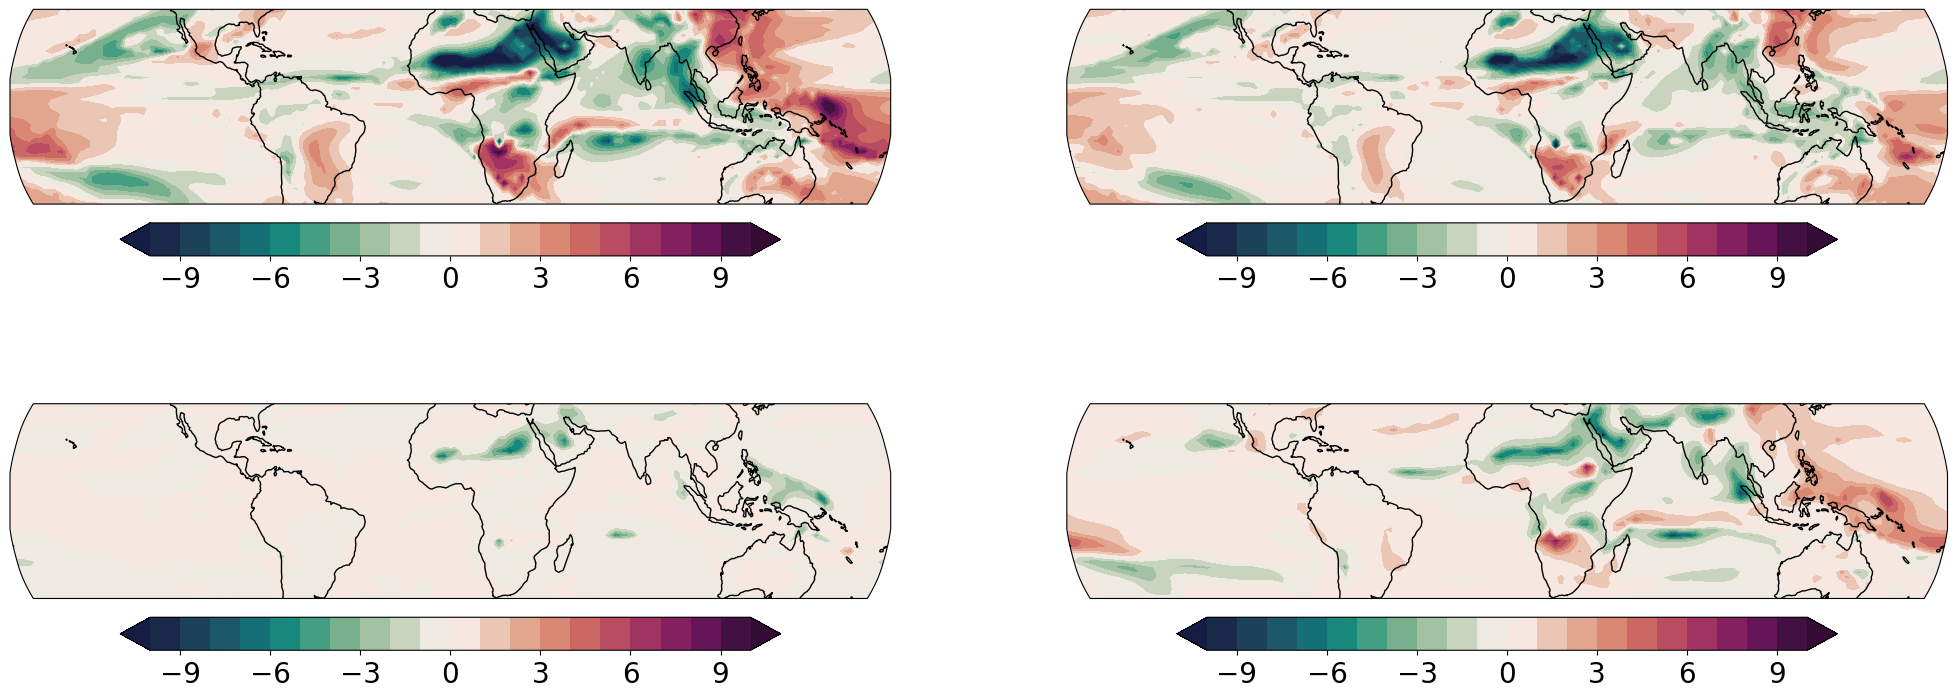

In [5]:
# --- MAP - 218gs - local vs regional anomalies 
fname = "localVregional_GS-218ka.png"
# ... select colormap
mycmap_d18 = cmo.curl

# isotope variable - decompositions
tau_totEffect = 'Dtau_bar'
tau_decomp_1 = 'Dtau_bar_localEffect_upwind_l1000' # 'Dtau_bar_localEffect_upwind_l750'
tau_decomp_2 = 'Dtau_bar_regEffect_upwind_g1000' # 'Dtau_bar_regEffect_upwind_g750'
tau_decomp_3 = 'Dtau_bar_localRegional_upwind_effectSum'
# d18 range
d18min, d18max = -10, 10

# ... set ylims
minlat, maxlat = -35, 35
# ... add cyclic point to remove bar at 0 lon
lon, lat = ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.).coords['lon'], ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.).coords['lat']
ds218gs_D18, lonc = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.)[tau_totEffect], coord=lon)
ds218gs_l, _ = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.)[tau_decomp_1], coord=lon)
ds218gs_r, _ = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.)[tau_decomp_2], coord=lon)
ds218gs_sum, _ = add_cyclic_point(ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.)[tau_decomp_3], coord=lon)

# colorbar properties
leg_shrink = 0.75    # [0-1]
leg_orient = "horizontal"
txtsize = 20



# ... PLOT [case minus ctrl]
spec = gridspec.GridSpec(ncols=2, nrows=2, hspace=0.05)
plt.figure(figsize=(25,10))

# TOP LEFT -- FULL ANOMALY; 218gs
ax = plt.subplot(spec[0], projection=ccrs.Robinson())
plt.contourf(lonc, lat, ds218gs_D18*tau_d18_scale, np.linspace(d18min, d18max, 21), 
             transform=ccrs.PlateCarree(), cmap=mycmap_d18, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents

# TOP RIGHT -- REGIONAL ANOMALY; 218gs
ax = plt.subplot(spec[1], projection=ccrs.Robinson())
plt.contourf(lonc, lat, ds218gs_r*tau_d18_scale, np.linspace(d18min, d18max, 21), 
             transform=ccrs.PlateCarree(), cmap=mycmap_d18, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents

# BOTTOM LEFT -- SUM LOCAL + REGIONAL; 218gs
ax = plt.subplot(spec[2], projection=ccrs.Robinson())
plt.contourf(lonc, lat, (ds218gs_sum-ds218gs_D18)*tau_d18_scale, np.linspace(d18min, d18max, 21), 
             transform=ccrs.PlateCarree(), cmap=mycmap_d18, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents

# BOTTOM RIGHT -- LOCAL ANOMALY; 218gs
ax = plt.subplot(spec[3], projection=ccrs.Robinson())
plt.contourf(lonc, lat, ds218gs_l*tau_d18_scale, np.linspace(d18min, d18max, 21), 
             transform=ccrs.PlateCarree(), cmap=mycmap_d18, extend='both') 
cb = plt.colorbar(orientation=leg_orient,pad=0.05,shrink=leg_shrink,label="") # create colorbar
cb.ax.tick_params(labelsize=txtsize)
ax.set_extent([-180, 180, minlat, maxlat], crs=ccrs.PlateCarree())
ax.coastlines() # add continents

# --- 
if figsave_on:
    plt.savefig(os.path.join(saveHere, fname), dpi=300, bbox_inches='tight', transparent=True)
# plt.show();
# plt.close();

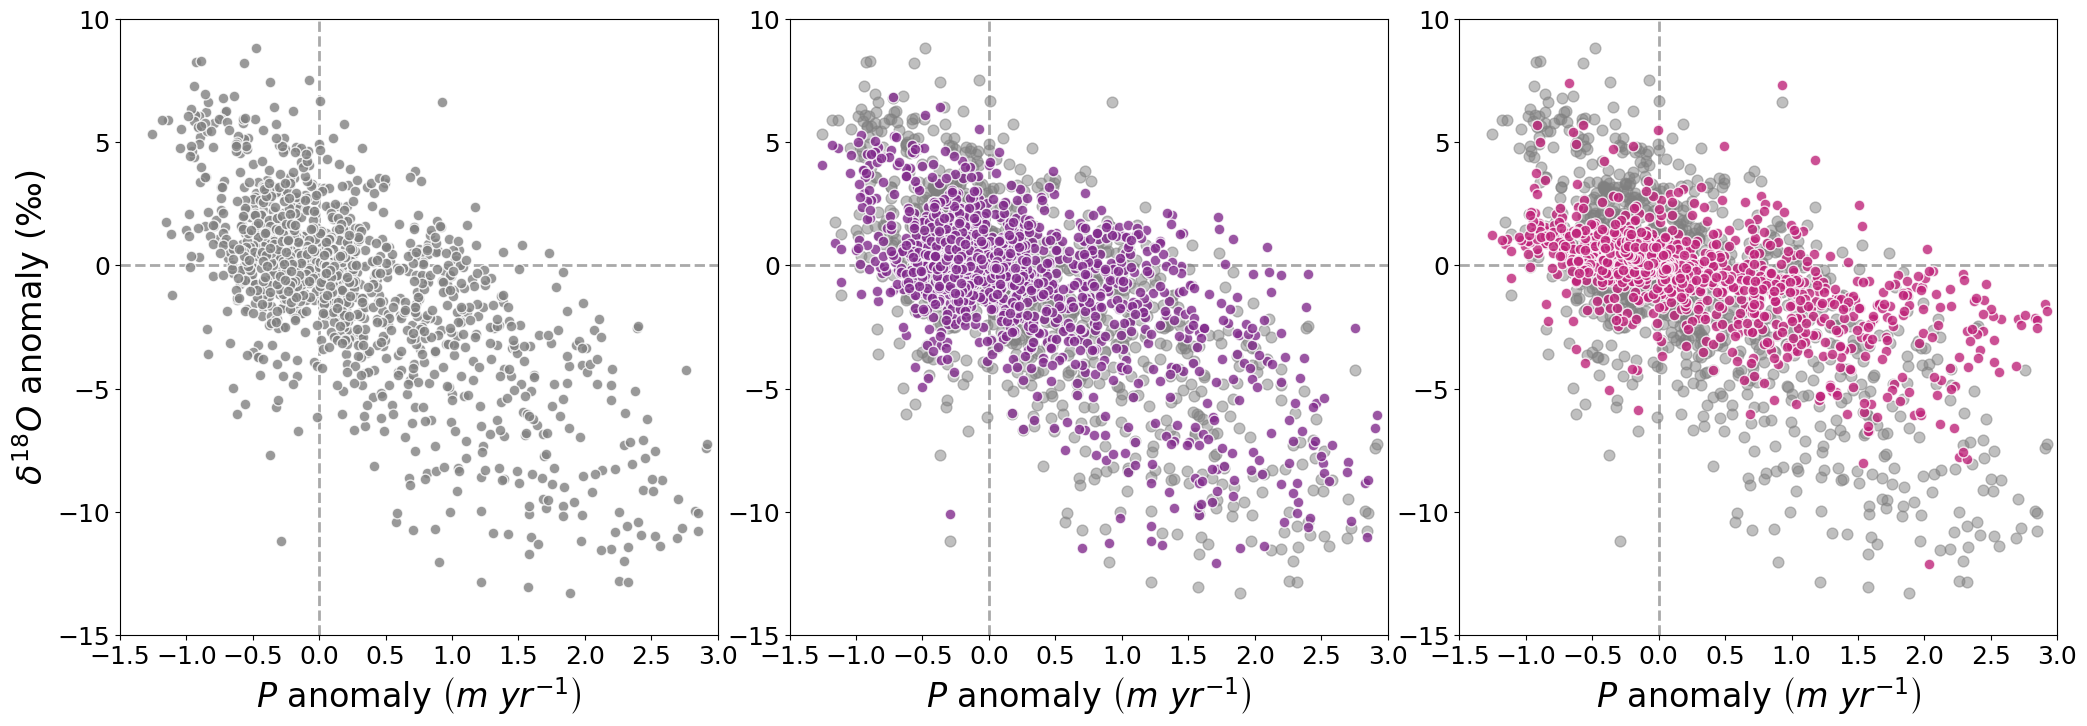

In [6]:
# --- THREE AMOUNT EFFECT PANELS
fname = "amtEff_3Panels_crossplot.png"
# ---

dsx_gs = ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=1.).copy()
dsx_ct = ds218gs.sel(lat=slice(minlat-1, maxlat+1), yr_slice='ann_prWtd', time=0.).copy()

# remove ocean cells
Diso = dsx_gs.where(dsx_gs['LANDFRAC']>0.7)['Dtau_bar'].values.flatten()
Diso_far = dsx_gs.where(dsx_gs['LANDFRAC']>0.7)['Dtau_bar_regEffect_upwind_g1000'].values.flatten()
Diso_close = dsx_gs.where(dsx_gs['LANDFRAC']>0.7)['Dtau_bar_localEffect_upwind_l1000'].values.flatten()
p1 = dsx_ct.where(dsx_ct['LANDFRAC']>0.7)['PRECT'].values.flatten()
p2 = dsx_gs.where(dsx_gs['LANDFRAC']>0.7)['PRECT'].values.flatten()

# pts aes
alp = 0.8   # transparency
alp_base = 0.5
psize = 60 
psize_base = 60
pcol_base1 = 'gray'
pcol_base2 = 'gray'
pcol_far = "#812B8C"
pcol_close = "#BF247A"
edgecol_base = 'white'

# zero line vars
lst = "dashed"
lwd = 2

# x range
prmin_s, prmax_s = -1500/1e3, 3000/1e3
# y range
dmin_x, dmax_x = -15, 10

# textsizes
ylabsize = 24
xlabsize = 24
xticksize, yticksize=18, 18

# ... PLOT [case minus ctrl]
spec = gridspec.GridSpec(ncols=3, nrows=1, hspace=0.015, wspace=0.12)
plt.figure(figsize=(25,8))

# FAR RIGHT -- FULL AMOUNT EFF
ax = plt.subplot(spec[0])
plt.scatter((p2-p1)*pFac/1000, Diso*tau_d18_scale, s=psize, alpha=alp, c=pcol_base1, edgecolors=edgecol_base)
plt.axvline(x=0, color='darkgray', linestyle=lst, linewidth=lwd, zorder=0)
plt.axhline(y=0, color='darkgray', linestyle=lst, linewidth=lwd, zorder=0)
plt.xlim(prmin_s, prmax_s)
plt.ylim(dmin_x, dmax_x)
plt.ylabel(r'$\delta^{18}O\ \mathrm{anomaly}\ \left(‰\right)$', fontsize=ylabsize) # https://stackoverflow.com/questions/23824687/text-does-not-work-in-a-matplotlib-label 
plt.xlabel(r'$P\ \mathrm{anomaly}\ \left(m\ yr^{-1}\right)$', fontsize=xlabsize)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=yticksize)

# MIDDLE -- DISTAL AMOUNT EFFECT
ax = plt.subplot(spec[1])
plt.scatter((p2-p1)*pFac/1000, Diso*tau_d18_scale, s=psize_base, alpha=alp_base, c=pcol_base2, zorder=1)
plt.scatter((p2-p1)*pFac/1000, Diso_far*tau_d18_scale, s=psize, alpha=alp, c=pcol_far, edgecolors=edgecol_base, zorder=2)
plt.axvline(x=0, color='darkgray', linestyle=lst, linewidth=lwd, zorder=0)
plt.axhline(y=0, color='darkgray', linestyle=lst, linewidth=lwd, zorder=0)
plt.xlim(prmin_s, prmax_s)
plt.ylim(dmin_x, dmax_x)
# plt.ylabel(r'$\delta^{18}O\ \mathrm{anomaly}\ \left(‰\right)$', fontsize=ylabsize) # https://stackoverflow.com/questions/23824687/text-does-not-work-in-a-matplotlib-label 
plt.ylabel('')
plt.xlabel(r'$P\ \mathrm{anomaly}\ \left(m\ yr^{-1}\right)$', fontsize=xlabsize)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=yticksize)

# MIDDLE -- DISTAL AMOUNT EFFECT
ax = plt.subplot(spec[2])
plt.scatter((p2-p1)*pFac/1000, Diso*tau_d18_scale, s=psize_base, alpha=alp_base, c=pcol_base2)
plt.scatter((p2-p1)*pFac/1000, Diso_close*tau_d18_scale, s=psize, alpha=alp, c=pcol_close, edgecolors=edgecol_base)
plt.axvline(x=0, color='darkgray', linestyle=lst, linewidth=lwd, zorder=0)
plt.axhline(y=0, color='darkgray', linestyle=lst, linewidth=lwd, zorder=0)
plt.xlim(prmin_s, prmax_s)
plt.ylim(dmin_x, dmax_x)
# plt.ylabel(r'$\delta^{18}O\ \mathrm{anomaly}\ \left(‰\right)$', fontsize=ylabsize) # https://stackoverflow.com/questions/23824687/text-does-not-work-in-a-matplotlib-label 
plt.ylabel('')
plt.xlabel(r'$P\ \mathrm{anomaly}\ \left(m\ yr^{-1}\right)$', fontsize=xlabsize)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=yticksize);



# --- 
if figsave_on:
    plt.savefig(os.path.join(saveHere, fname), dpi=300, bbox_inches='tight', transparent=True)